**Stratified LD Score Regression (S-LDSC) Pipeline for Calculating Functional Enrichment and LD Scores**

This notebook implements the pipepline for S-LDSC using python 2.7 and implementing the methods for ld score and enrichment calculations using the code defined in the [S-LDSC github repo](https://github.com/bulik/ldsc/wiki).

Author: Anmol Singh, email: singh.anmol@columbia.edu, with input from Dr. Gao Wang

**Overview**

This pipeline has been developed to integrate GWAS summary statistics data, annotation data, and LD reference panel data to compute functional enrichment for each of the epigenomic annotations that the user provides using the S-LDSC model. 

## Introduction:


To begin I will just give a brief introduction on LD Score Regression and what it is used for. For more in depth information on LD Score Regression please read the following three papers:

1. "LD Score regression distinguishes confounding from polygenicity in genome-wide association studies" by Sullivan et al (2015)

2. "Partitioning heritability by functional annotation using genome-wide association summary statistics" by Finucane et al (2015)

3. "Linkage disequilibrium–dependent architecture of human complex traits shows action of negative selection" by Gazal et al (2017)

As stated in Sullivan et al 2015, confounding factors and polygenic effects can cause inflated test statistics and other methods cannot distinguish between inflation from confounding bias and a true signal.

Thus, LD Score Regression or LDSC is a technique that aims to identify the impact of confounding factors and polygenic effects using information from GWAS summary statistics.

This approach involves using regression to mesaure the relationship between Linkage Disequilibrium (LD) scores and test statistics of SNPs from the GWAS summary statistics. 

Variants in LD with a causal variant show an elevation in test statistics in association analysis proportional to their LD (measured by r2) with the causal variant within a certain window size (could be 1 cM, 1kB, etc.). 

In contrast, inflation from confounders such as population stratification that occur purely from genetic drift will not correlate with LD.

Thus, if we regress the χ2 statistics from GWAS against LD Score (LD Score regression), the intercept minus one is an estimator of the mean contribution of confounding bias to the inflation in the test statistics.

Useful Formula to Help Explain LD Score Regression: 
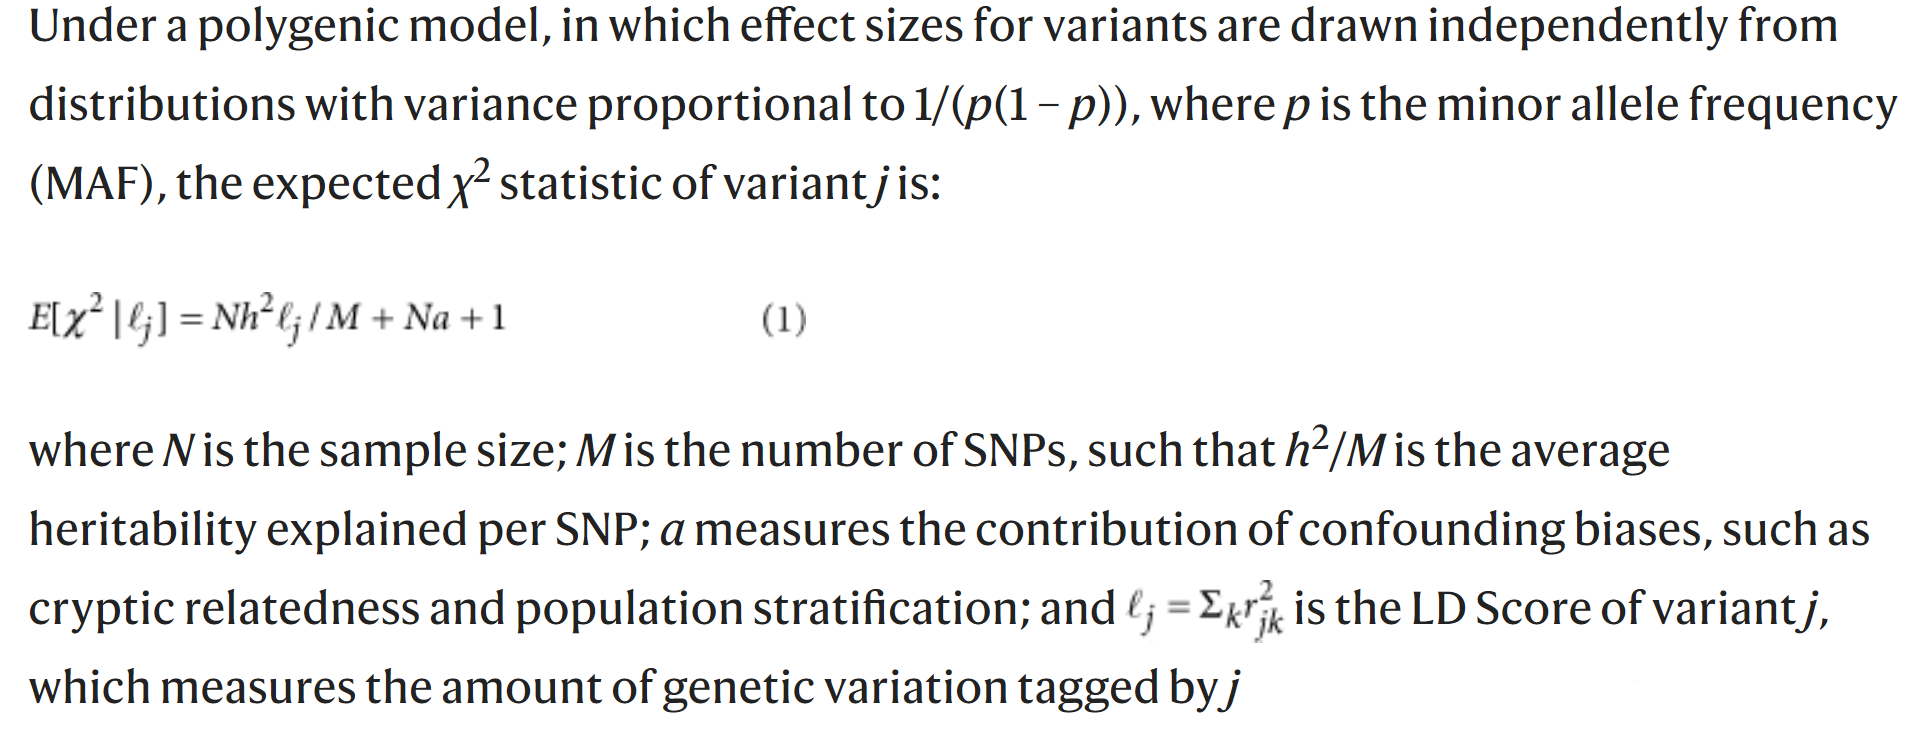

(a full derivation of this equation is provided in the Supplementary Note of Sullivan et al (2015))





From this we can see that, LD Score regression is useful in determining SNP-based heritability for a phenotype or trait.

Heritability is the proportion of phenotypic variation (VP) that is due to variation in genetic values (VG) and thus can tell us how much of the difference in observed phenotypes in a sample is due to difference in genetics in the sample.

But it can also be used to analyze partitioned heritability for a phenotype/trait split over categories. 

For Partitioned Heritability or Stratified LD Score Regression (S-LDSC) more power is added to our analysis by leveraging LD Score information as well as using SNPs that haven't reached Genome Wide Significance to partition heritability for a trait over categories which many other methods do not do. 

Furthermore, S-LDSC only requires that we have summary statistics for our SNPs and does not require genotype information like other methods such as REML do. 

S-LDSC relies on the fact that the χ2 association statistic for a given SNP includes the effects of all SNPs tagged by this SNP meaning that in a region of high LD in the genome the given SNP from the GWAS represents the effects of a group of SNPs in that region.

Thus, for a polygenic trait, SNPs with a high LD score will have more significant χ2 statistics on average than SNPs with a low LD score.

S-LDSC determines that a category of SNPs is enriched for heritability if SNPs with high LD to that category have more significant χ2 statistics than SNPs with low LD to that category.

Here, enrichment of a category is defined as the proportion of SNP heritability in the category divided by the proportion of SNPs in that category.

This formula is very useful to see how S-LDSC works:

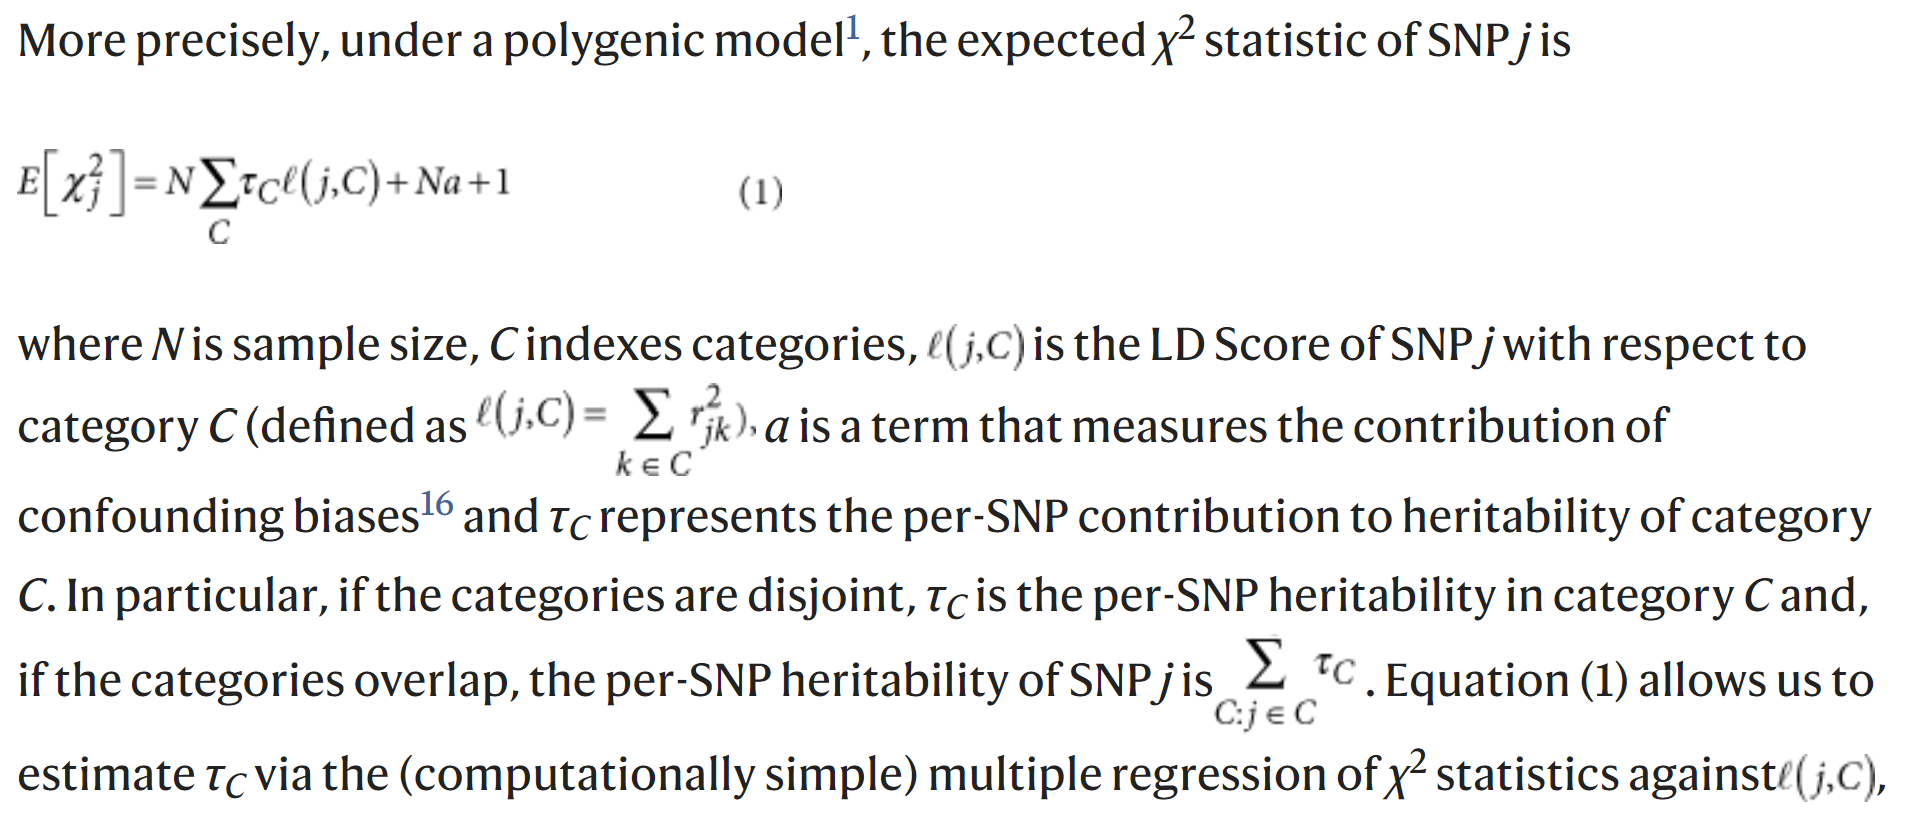


To see how these methods have been applied to real world data as well as a further discussion on methods and comparisons to other methods please read the three papers listed at the top of the tutorial. 

We will discuss how to conduct both types of LD Score regression in this tutorial using the ldsc program which can be found here: https://github.com/bulik/ldsc.



## Installing LDSC with Conda:

Make sure that you have installed python 2 and conda (if you want to install ldsc using conda). Conda can be installed using this link: https://store.continuum.io/cshop/anaconda/.

### Step 1: Clone the Github Repository

`git clone https://github.com/bulik/ldsc.git`

`cd ldsc`

### Step 2: Activate the Conda Environment

`conda env create --file environment.yml`

`source activate ldsc`

### Step 3: Check to see if the main python scripts used for analysis are executable

`./ldsc.py -h`

`./munge_sumstats.py -h`

Check to make sure that both `./ldsc.py -h` and `./munge_sumstats.py -h` output the list of all possible commands for both, otherwise there is something wrong with the installation.

## Installing LDSC without Conda:

### Step 1: Clone the Github Repository

`git clone https://github.com/bulik/ldsc.git`

`cd ldsc`

### Step 2: Make the python scripts executeable

`chmod +x ldsc.py`

`chmod +x munge_sumstats.py`

### Step 3: Check to see if the main python scripts used for analysis are executable

`./ldsc.py -h`

`./munge_sumstats.py -h`

Since pybedtools is required for make_annot.py, if you need to make binary annotations and did not install through conda you must either install pybedtools on the cluster or use it through this docker image.

### Step 4: Load Docker Image that has pybedtools

`module load Singularity`

`module load R`

`singularity pull docker://quay.io/biocontainers/pybedtools-0.8.0-py27he860b03_1`

Through this image you will now be able to use the make_annot.py script with no issues. 

## Analysis 1: Simple LD Score Regression

This is a simple example of non-partitioned LD Score Regression.

You can find the plink files needed for this tutorial here: https://data.broadinstitute.org/alkesgroup/LDSCORE/1000G_Phase3_plinkfiles.tgz. This file contains the bim/bam/fam files for 489 subjects for all 1000 Genome Phase 3 SNPs which will be used as the reference panel for our analysis.

Now, after downloading the data we can take a look at a simple example calculating the LD scores for 1000 Genome Phase 3 variants on chromosome 22. To conduct the regression we must do this for every chromosome but the commands are the same so I will just show it for one. A great way that I have found to loop over all the chromosomes in parallel is to use xargs:

seq 1 22| xargs -n 1 -I j -P 4 python ldsc.py --bfile 1000G.EUR.QC.j --l2 --ld-wind-cm 1 --out tutorial.j &

This xargs command will loop over the command passed to it using the iterative variable j (marked with the -I flag). The -n 1 flag indicates that there is one iterative variable and the -P 4 flag indicates that 4 of the iterative commands will be submitted at a time (e.g. chr1,chr2,chr3,chr4 will be submitted in a batch and then after that is done the next 4 will start).

Make sure you set the shell to Bash if you would like to run the commands yourself
For the command flags: --bfile indicates that the file is a plink bed/bim/fam file with that prefix, --l2 indicates you want to calculate LD Scores, --ld-wind-cm indicates that you want to calculate LD Scores using a 1 cM window, and --out indicates the prefix you want to use for output files

In [ ]:
sos run LDSC.ipynb simple_ld_score\
    --bfile 1000G.EUR.QC.22\
    --l2\
    --ld-wind-cm 1\
    --out tutorial.22 

The output of this command shows a summary of the LD Scores and the MAF/LD Score correlation matrix which is useful for conducting QC on the analysis. The MAF and LD Scores should be positively correlated.

The command also creates a file with the LD Scores that are gzipped. An example output is shown below.

In [ ]:
zless tutorial.22.l2.ldscore.gz | head

After calculating LD Scores for each chromosome, it is time to set up the summary statistic file for the phenotype you are trying to analyze. The summary statistic file we will use is for BMI and it can be downloaded here: http://www.broadinstitute.org/collaboration/giant/index.php/GIANT_consortium_data_files. For the tutorial you also need the list of hapmap snps to restrict the summary statistic file to the recommended HapMap Phase 3 SNPs that will be used in the regression. The authors recommend restricting the analysis to HapMap Phase 3 SNPs because most GWAS summary statistics do not have information about imputation quality, thus using HapMap SNPs insures that you are using well-imputed and common variants for the analysis. This file can be downloaded here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/w_hm3.snplist.bz2. The summary statistic file should have the following columns with the following names for the analysis to work:

SNP -- SNP identifier (e.g., rs number)

N -- sample size (which may vary from SNP to SNP).

P -- p-value.

A1 -- first allele (effect allele)

A2-- second allele (other allele)

Signed Summary Statistic (Can be Z, BETA, or Odds Ratio(label as OR)), is optional if A1 is the risk increasing allele as you can put the flag --a1-inc in the command and ldsc will calculate the Z score for the SNPs for you

Once you have set up the summary statistic file with these column headers you can reformat it for the analysis using the following command:

In [ ]:
sos run LDSC.ipynb munge_sumstats --sumstats GIANT_BMI_Speliotes2010_publicrelease_HapMapCeuFreq.txt\
--merge-alleles w_hm3.snplist\
--out BMI\
 --a1-inc

This will return a file called BMI.sumstats.gz which is a gzipped file that will be used as the summary statistic file in our analysis. It contains a row for each variant as well as the Allele Information and the Z score calculated by the munge_sumstats.py program.

Now we can conduct the Simple LD Score Regression using the following command listed below. We will have to download the weights for all hapmap snps excluding the HLA gene region for this analysis, which can be found here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/weights_hm3_no_hla.tgz. The authors excluded the HLA gene region due to the unusual genetic architecture and LD pattern in this region.

For the command flags: --h2 indicates that you want to conduct LD Score regression using the gzipped summary statistic file we made in the last part, --ref-ld-chr indicates the reference genome LD Scores which were calculated in the section above, --w-ld-chr indicates the files that contains weights for the regression SNPs that the program can use.

In [ ]:
sos run LDSC.ipynb enric_simple \
--h2 BMI.sumstats.gz \
--ref-ld-chr tutorial. \
--w-ld-chr ./weights_hm3_no_hla/weights. \
--out tutorial_1

Now we have estimated the proportion of heritability that is attributed to the BMI phenotype which is shown in the output above. Note that this value should be between 0 and 1 but can be a bit below 0 due to standard errors during calculation.

Heritability is formally defined as the proportion of phenotypic variation (VP) that is due to variation in genetic values (VG).

Thus, in this case the proportion of phenotypic variance for BMI that is due to genetic factors is relatively low.

Lambda GC is the genomic inflation factor which tells us how much systematic bias is present in our data, it is calculated in this case by median(chi^2)/0.4549. The value should be close to 1.

Mean chi^2 is the mean chi-square statistic and should be above 1.02.

Intercept is the LD Score regression intercept. The intercept should be close to 1, unless the data have been corrected for GC bias or Genomic Control Bias which controls for bias from population stratification, in which case it will often be lower. Note that the intercept in our case is below 1 because the summary statistics file we used has been corrected for GC bias.

Ratio is (intercept-1)/(mean(chi^2)-1), which measures the proportion of the inflation in the mean chi^2 that the LD Score regression intercept ascribes to causes other than polygenic heritability. The value of ratio should be close to zero, though in practice values of 10-20% are not uncommon, probably due to sample/reference LD Score mismatch or model misspecification (e.g., low LD variants have slightly higher h^2 per SNP).

### Analysis 2: Partitioned LD Score Regression
Now there are two cases that are possible for Partitioned LD Score Regression using the ldsc program, binary and continuous. Both cases require a baseline model for comparison purposes. For this we will use the baseline model provided by the ldsc program which consists of 53 overlapping binary annotations. The LD Scores for the baseline model can be downloaded here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/1000G_Phase3_baseline_ldscores.tgz.

Binary Annotations:
We first make the annotation file with respect to a specific annotation bed file using the make_annot.py script that comes with the ldsc program. For the purposes of this tutorial we will use a Histone Mark annotation from Adipose Tissue, Adipose_Tissue.H3K27ac. I have provided the bed file for this annotation on the google drive folder so you can download it to run the commands below. The command to make the annotation file for this annotation for one chromosome of the 1000 Genome Phase 3 variants (the reference data) for the tutorial is listed here:

In [ ]:
sos run LDSC.ipynb make_annot \
		--bed-file Adipose_Tissue.H3K27ac.bed \
		--bimfile 1000G.EUR.QC.22.bim \
		--annot-file Adipose_Tissue.H3K27ac.annot.gz

This command will output a file with 0/1 for each variant in the bim file which corresponds to whether this specific variant is within the regions described in the annotation file.

After the annotation file is made we can use it to calculate the LD Scores for this annotation. This will be done using the command below for chromosome 22, remember you have to repeat the same command for every chromsome in the reference panel. In this case the program recommends that you only print LD Scores for HapMap Phase 3 SNPs. This can be achieved by using the hapmap snplist file which can be found here: https://storage.googleapis.com/broad-alkesgroup-public/LDSCORE/w_hm3.snplist.bz2.

For this command the difference is that we add the --annot flag which indicates the annotation file we are using and the --thin-annot flag which indicates that the annotation file does not contain any information about the SNPs (rs number, CHR, and BP) and only contains the binary scores for the annotation.

Make sure your annotation files have the same prefix as your LD Score files that you will create as ldsc will not be able to read the annotation files if they have a different prefix when you try to conduct the regression.

In [ ]:
sos run LDSC.ipynb ld_score \
    --bfile 1000G.EUR.QC.22\
    --l2\
    --ld-wind-cm 1 --annot Adipose_Tissue.H3K27ac.22.annot.gz --thin-annot\
    --out Adipose_Tissue.H3K27ac.22\
    --print-snps w_hm3.snplist

This command outputs the same gzipped LD score file as the simple case but instead of just an LD Score column, it will have one LD Score column for each annotation that you are calculating LD Scores for.

In [ ]:
zless Adipose_Tissue.H3K27ac.22.l2.ldscore.gz | head

Now that we have calculated the LD Scores for each chromosome for our annotation, we can use these LD Scores to conduct the Partitioned LD Score Regression for our annotation. In this case we have to make sure that our annotation files are in the same folder and have the same prefix name as our LD Score files. Now we can conduct the Regression for our annotation:

The new flag --frqfile-chr is used to add the MAF frequencies for the reference genome SNPs since we will only be using SNPs with a MAF>0.05 to conduct the analysis.

In [ ]:
sos run LDSC.ipynb enric \
    --h2 BMI.sumstats.gz\
    --ref-ld-chr baseline.,Adipose_Tissue.H3K27ac.\ 
    --w-ld-chr weights_hm3_no_hla/weights.\
    --overlap-annot\
    --frqfile-chr 1000G_frq/1000G.mac5eur.\
    --out Adipose_Tissue.H3K27ac


Here the comma indicates that we are concatinating the baseline model with the new annotation.

The results our outputted in a .results file which shows the proportion of heritability and enrichment attributable to each category for the trait you are studying, in this case BMI.

The results file for this analysis looks like this:

In [ ]:
zless Adipose_Tissue.H3K27ac.results | head -n 5

zless Adipose_Tissue.H3K27ac.results | tail -n 5

## Workflow:

### 